In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib64/jvm/jre-1.8.0-openjdk"
from pyspark.sql import SparkSession
home =  os.path.expanduser("~")
spark = SparkSession \
    .builder \
    .appName("Project4 - COVID-19") \
    .config("spark.driver.memory", "15g") \
    .config('spark.driver.maxResultSize', '15g') \
    .getOrCreate()

## Step 1: Read the data (the json files and metadata)

### Read the metadata file

In [2]:
metadata = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load(home+"/Dataset/metadata.csv")

### We begin by randomly sampling 10,000 papers from the pdf_json folder. We can do this through the following linux command, utilizing the `shuf` command
`~  shuf -zn10000 -e document_parses/pdf_json/* | xargs -0 cp -vt random_sample/`

### Read the sample

In [3]:
papers = spark.read\
            .format("json")\
            .option("multiLine", "true")\
            .load(home+"/Dataset/random_sample/")

## Step 2: Explore the data

### From the metadata exploration we found that many columns has nulls and some are only nulls

In [4]:
metadata.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)
 |-- s2_id: string (nullable = true)



In [5]:
metadata.show(5)

+--------+--------------------+--------+--------------------+--------------------+--------+---------+-------+--------------------+------------+--------------------+--------------+------+----------------+--------+--------------------+--------------------+--------------------+-----+
|cord_uid|                 sha|source_x|               title|                 doi|   pmcid|pubmed_id|license|            abstract|publish_time|             authors|       journal|mag_id|who_covidence_id|arxiv_id|      pdf_json_files|      pmc_json_files|                 url|s2_id|
+--------+--------------------+--------+--------------------+--------------------+--------+---------+-------+--------------------+------------+--------------------+--------------+------+----------------+--------+--------------------+--------------------+--------------------+-----+
|ug7v899j|d1aafb70c066a2068...|     PMC|Clinical features...|10.1186/1471-2334...|PMC35282| 11472636|  no-cc|OBJECTIVE: This r...|  2001-07-04|Madani, Tar

In [6]:
from pyspark.sql.functions import isnan, when, count, col

metadata.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in metadata.columns]).show()

+--------+-----+--------+-----+-----+-----+---------+-------+--------+------------+-------+-------+------+----------------+--------+--------------+--------------+-----+-----+
|cord_uid|  sha|source_x|title|  doi|pmcid|pubmed_id|license|abstract|publish_time|authors|journal|mag_id|who_covidence_id|arxiv_id|pdf_json_files|pmc_json_files|  url|s2_id|
+--------+-----+--------+-----+-----+-----+---------+-------+--------+------------+-------+-------+------+----------------+--------+--------------+--------------+-----+-----+
|       0|77267|       0|   30|29459|71159|    32790|     41|   29300|          44|   4995|   6651|133300|          113503|  132417|         75636|         87526|11453|28314|
+--------+-----+--------+-----+-----+-----+---------+-------+--------+------------+-------+-------+------+----------------+--------+--------------+--------------+-----+-----+



### The json files schema is available in the dataset where we found all the info we need

In [7]:
papers.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            abstract|         back_matter|         bib_entries|           body_text|            metadata|            paper_id|         ref_entries|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                  []|[[[[48,, 44, 3.37...|[, [[[H, Adams, [...|[[[], [[79, TABRE...|[[[[,,], , , Bert...|2b1cbb43a4f06e232...|[[, Chest Wall Th...|
|[[[], [], Abstrac...|[[[], [], acknowl...|[[[], , [,,,], , ...|[[[[1203,, 1200, ...|[[[[,,], , ;, Bey...|c9f4a4df803f6496b...|[[, Figure 2, fig...|
|                  []|[[[[1609,, 1586, ...|[[[[T, Aaberg, [M...|[[[[505,, 497, Ka...|              [[], ]|5c6c26e79c0824645...|[,, [, Technische...|
|                  []|[[[], [], annex, ...|[[[[Organizationa...|[[[], [], , LEARN...|[[[[University of...|

## Now we need to process the json files and get the info we need in a simple structured dataframe

### Define a function to gather all paragraphs in one text
### and gather abstract paragraphs and body paragraphs

In [8]:
from pyspark.sql.functions import udf

def concatenate_text(j):
    txt_all = ""
    for a in j:
        txt_all = txt_all + " " + a['text']
    return txt_all

udf_concatenate_text = udf(concatenate_text)

In [9]:
papers = papers.select(papers['Paper_ID'], papers['metadata']['title'], udf_concatenate_text(papers['abstract']), udf_concatenate_text(papers['body_text']))

In [10]:
papers.printSchema()

root
 |-- Paper_ID: string (nullable = true)
 |-- metadata.title: string (nullable = true)
 |-- concatenate_text(abstract): string (nullable = true)
 |-- concatenate_text(body_text): string (nullable = true)



In [11]:
papers = papers.withColumnRenamed('metadata.title', 'title')\
        .withColumnRenamed('concatenate_text(abstract)', 'abstract')\
        .withColumnRenamed('concatenate_text(body_text)', 'body')

In [12]:
papers.show(10)

+--------------------+--------------------+--------------------+--------------------+
|            Paper_ID|               title|            abstract|                body|
+--------------------+--------------------+--------------------+--------------------+
|2b1cbb43a4f06e232...|Level 3 guideline...|                    | S3-guideline on ...|
|c9f4a4df803f6496b...|Physicians Poster...| Background: Prom...| with Thiotepa 5 ...|
|5c6c26e79c0824645...|                    |                    | Der Weltgesundhe...|
|38c0691ee76fb1e66...|Society of Genera...|                    | LEARNING OBJECTI...|
|67c8d389c28ceef26...|        Diedrich (1)|                    | The presence of ...|
|8c93a69ce8eb2ba08...|                    |                    | July-December 20...|
|e3b74d02ad582540a...|P1-A03A IgG Subty...| Background/Case ...| Background/Case ...|
|7e62ae259b327bda2...|                    |                    | Definitions. The...|
|a78f60c67c8ac17c7...|Alterations in 14...|           

### Seems that some fields have empty values, let's explore that

In [13]:
from pyspark.sql.functions import isnan, when, count, col

papers.select([count(when(col(c) == "", c)).alias(c) for c in papers.columns]).show()

+--------+-----+--------+----+
|Paper_ID|title|abstract|body|
+--------+-----+--------+----+
|       0| 1060|    2927|   0|
+--------+-----+--------+----+



## Step 3: Prepare and process the data

### Now join the papers dataframe the metadata and get only the columns that we might use as features

In [14]:
papers_meta = papers.join(metadata, papers['Paper_ID'] == metadata['sha'], how='left_outer')\
            .select(papers['Paper_ID'], papers['title'], papers['body'], metadata['publish_time'],\
                   metadata['authors'], metadata['journal'])

In [15]:
from pyspark.sql.functions import year, month, to_date
papers_meta = papers_meta.withColumn("publish_Year", year(to_date("publish_time")))\
                        .withColumn("publish_Month", month(to_date("publish_time")))

In [16]:
papers_meta.show(5)

+--------------------+--------------------+--------------------+------------+--------------------+--------------------+------------+-------------+
|            Paper_ID|               title|                body|publish_time|             authors|             journal|publish_Year|publish_Month|
+--------------------+--------------------+--------------------+------------+--------------------+--------------------+------------+-------------+
|0782b4fb23ca65baf...|The population ge...| The model will b...|  2015-11-30|Tibayrenc, Michel...|        Acta Tropica|        2015|           11|
|14d8fd027f39c8311...|Drug-Induced Dela...| Drug-induced del...|  2015-05-15|Klimas, Natasha; ...|Cutaneous Drug Er...|        2015|            5|
|1e5228e3f0658479a...|Canonicalizing Kn...| User-generated c...|  2020-04-17|Fatma, Nausheen; ...|Advances in Knowl...|        2020|            4|
|1e663ac169e08ea02...|The effects of a ...| Evidence has bee...|  2006-07-31|Yip, Paul S.F.; F...|Journal of Affect...

### Define a function to detect the paper language and filter out non-english papers

In [17]:
from langdetect import detect
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return None
udf_detect_lang = udf(detect_lang)

In [18]:
papers_meta = papers_meta.withColumn('Lang', udf_detect_lang(papers_meta['body']))

In [19]:
## some papers are indeed non English
papers_meta.select("*").where("Lang<>'en'").show(5)

+--------------------+--------------------+--------------------+------------+--------------------+--------------------+------------+-------------+----+
|            Paper_ID|               title|                body|publish_time|             authors|             journal|publish_Year|publish_Month|Lang|
+--------------------+--------------------+--------------------+------------+--------------------+--------------------+------------+-------------+----+
|8b99371978aab17bc...|                    | Pierre BÉGUÉ * A...|  2017-12-31|       Bégué, Pierre|Bulletin de l'Aca...|        2017|           12|  fr|
|a97968e164a378d7d...|LE UN BOCAVIRUS H...| 6 -infection res...|  2006-11-30|Foulongne, Vincen...|Revue Francophone...|        2006|           11|  fr|
|2806abcfcda76ad3e...|Journal Pre-proof...| grave de los cua...|  2020-04-29|Martino, Marcello...|                null|        2020|            4|  es|
|8623787ac0fead8e9...|2 Infecties van d...| Luchtweginfectie...|        2011|de Jong, M.

In [20]:
papers_meta.count()

10017

In [21]:
papers_meta = papers_meta.filter(papers_meta['Lang'] == 'en')

In [22]:
papers_meta.count()

9638

In [23]:
#Drop the unneeded columns
papers_meta = papers_meta.drop('publish_time', 'Lang')
papers_meta.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------------+
|            Paper_ID|               title|                body|             authors|             journal|publish_Year|publish_Month|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------------+
|0782b4fb23ca65baf...|The population ge...| The model will b...|Tibayrenc, Michel...|        Acta Tropica|        2015|           11|
|14d8fd027f39c8311...|Drug-Induced Dela...| Drug-induced del...|Klimas, Natasha; ...|Cutaneous Drug Er...|        2015|            5|
|1e5228e3f0658479a...|Canonicalizing Kn...| User-generated c...|Fatma, Nausheen; ...|Advances in Knowl...|        2020|            4|
|1e663ac169e08ea02...|The effects of a ...| Evidence has bee...|Yip, Paul S.F.; F...|Journal of Affect...|        2006|            7|
|1f26b5e8291ea1ddc...|The Case for Labo...| The field of pat..

### We will periodically save the dataframes we are working on in parquet format with 12 partitions (the number of logical cores in our machine) for performance improvements.

In [24]:
## Save what we have so far
papers_meta.repartition(12).write.parquet("./Dataset/papers_meta")

In [2]:
#papers_meta = spark.read\
#            .format("parquet")\
#            .option("header", "true")\
#            .load("./Dataset/papers_meta")

### Find which columns contain null or unknown values and replace them with " " for categorical and 0 for numerical

### Count Nulls and Empty values in each column to understand more about the data

In [3]:
from pyspark.sql.functions import isnan, when, count, col
print("Count of Null")
papers_meta.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in papers_meta.columns]).show()
print("Count of Empty values")
papers_meta.select([count(when(col(c) == "", c)).alias(c) for c in papers_meta.columns]).show()

Count of Null
+--------+-----+----+-------+-------+------------+-------------+
|Paper_ID|title|body|authors|journal|publish_Year|publish_Month|
+--------+-----+----+-------+-------+------------+-------------+
|       0|    0|   0|   1252|   1817|        1127|         1127|
+--------+-----+----+-------+-------+------------+-------------+

Count of Empty values
+--------+-----+----+-------+-------+------------+-------------+
|Paper_ID|title|body|authors|journal|publish_Year|publish_Month|
+--------+-----+----+-------+-------+------------+-------------+
|       0|  933|   0|      0|      0|           0|            0|
+--------+-----+----+-------+-------+------------+-------------+



In [4]:
cat_cols = [item[0] for item in papers_meta.dtypes if item[1].startswith('string')] 
cat_cols

['Paper_ID', 'title', 'body', 'authors', 'journal']

In [5]:
from pyspark.sql.functions import col

cat_null_cols = [column for column in cat_cols if papers_meta.where(col(column).isNull()| col(column).isin('')).count() > 0]
cat_null_cols

['title', 'authors', 'journal']

In [6]:
### Now let's fill with " "
for column in cat_null_cols:
    papers_meta = papers_meta.na.fill(" ")

In [7]:
num_cols = [item[0] for item in papers_meta.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
num_cols

['publish_Year', 'publish_Month']

In [8]:
### Now let's find numerical columns with null values
num_null_cols = [column for column in num_cols if papers_meta.filter(col(column).isNull() | col(column).eqNullSafe(0)).count() > 0]
num_null_cols

['publish_Year', 'publish_Month']

In [9]:
### Now let's fill with 0
for column in num_null_cols:
    papers_meta = papers_meta.na.fill(0)

In [10]:
papers_meta.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------------+
|            Paper_ID|               title|                body|             authors|             journal|publish_Year|publish_Month|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------------+
|012b16ae54779ca1a...|Synchronized Bive...| Miniaturized imp...|Lyu, Hongming; Jo...|             Sci Rep|        2020|            2|
|01bc7fe59fc7feb0e...|Open Forum Infect...| Acute upper resp...|Joseph, Patrick; ...|Open Forum Infect...|        2018|            2|
|0240a12c9fdf6c031...|Supersize me: how...| In epidemiology,...|Kao, Rowland R.; ...|Trends in Microbi...|        2014|            5|
|03bfb747583f6b214...|The Infant Nasoph...| The human microb...|                    |                    |           0|            0|
|06e9041ff3cb1db28...|Selected Nonvacci...| A cute respirato..

### Now drop duplicates rows (No duplicates found in our sample)

In [11]:
papers_meta.count()
papers_meta.dropDuplicates()

DataFrame[Paper_ID: string, title: string, body: string, authors: string, journal: string, publish_Year: int, publish_Month: int]

In [12]:
papers_meta.count()

9639

In [13]:
## Save what we have so far
papers_meta.repartition(12).write.parquet("./Dataset/papers_meta_cleaned")

In [14]:
papers_meta = spark.read\
            .format("parquet")\
            .option("header", "true")\
            .load("./Dataset/papers_meta_cleaned")

## Step 4 (Preprocessing)

### Now let's start the Processing phase for the papers body and title

In [15]:
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover

#### Convert the body text to lower case
#### Remove Punctuation

In [16]:
from pyspark.sql.functions import col

papers_meta = papers_meta.withColumn("body", lower(col('body')))
papers_meta = papers_meta.withColumn("body", regexp_replace("body", "[^a-zA-Z\\s]" , " "))
papers_meta = papers_meta.withColumn("body", regexp_replace("body", " +" , " "))
papers_meta = papers_meta.withColumn("body", regexp_replace("body", "^ +" , ""))

In [17]:
papers_meta = papers_meta.withColumn("title", lower(col('title')))
papers_meta = papers_meta.withColumn("title", regexp_replace("title", "[^a-zA-Z\\s]" , " "))
papers_meta = papers_meta.withColumn("title", regexp_replace("title", " +" , " "))
papers_meta = papers_meta.withColumn("title", regexp_replace("title", "^ +" , ""))

In [18]:
papers_meta.show(10)

+--------------------+--------------------+--------------------+--------------------+------------+------------+-------------+
|            Paper_ID|               title|                body|             authors|     journal|publish_Year|publish_Month|
+--------------------+--------------------+--------------------+--------------------+------------+------------+-------------+
|002f213aeda7ce843...|etiology and impa...|community acquire...|Nolan, Vikki G; A...|J Infect Dis|        2018|            7|
|0297dd12949520da3...|optimization of p...|the localization ...|Quintana, C.; Mar...|      Micron|        1998|            8|
|09045f5964f24691f...|evaluation of tnf...|the toxic effects...|Rook, Graham A. W...|  Biotherapy|        1991|            1|
|0e3da58a0d46d88ee...|the influence of ...|increasing our un...|                    |            |           0|            0|
|103c89c60d7d24bb8...|does pathogen spi...|pathogen outbreak...|Otterstatter, Mic...|    PLoS One|        2008|       

#### Tokenize the paper body text and title text

In [19]:
tokenizer = Tokenizer(inputCol='body', outputCol='words_token')
papers_meta = tokenizer.transform(papers_meta).select('*')

In [20]:
tokenizer = Tokenizer(inputCol='title', outputCol='title_token')
papers_meta = tokenizer.transform(papers_meta).select('*')

In [21]:
papers_meta.select('words_token', 'title_token').show(10)

+--------------------+--------------------+
|         words_token|         title_token|
+--------------------+--------------------+
|[community, acqui...|[etiology, and, i...|
|[the, localizatio...|[optimization, of...|
|[the, toxic, effe...|[evaluation, of, ...|
|[increasing, our,...|[the, influence, ...|
|[pathogen, outbre...|[does, pathogen, ...|
|[immunoglobulin, ...|[immunoglobulin, ...|
|[the, novel, coro...|[center, for, med...|
|[several, graph, ...|[generalized, lat...|
|[severe, acute, r...|[sars, coronaviru...|
|[the, year, occas...|[genetic, cellula...|
+--------------------+--------------------+
only showing top 10 rows



#### Remove stop words

In [22]:
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
papers_meta = remover.transform(papers_meta).select('*')

In [23]:
remover = StopWordsRemover(inputCol='title_token', outputCol='title_clean')
papers_meta = remover.transform(papers_meta).select('*')

In [24]:
papers_meta.select('words_clean', 'title_clean').show(10)

+--------------------+--------------------+
|         words_clean|         title_clean|
+--------------------+--------------------+
|[community, acqui...|[etiology, impact...|
|[localization, ch...|[optimization, ph...|
|[toxic, effects, ...|[evaluation, tnf,...|
|[increasing, unde...|[influence, clima...|
|[pathogen, outbre...|[pathogen, spillo...|
|[immunoglobulin, ...|[immunoglobulin, ...|
|[novel, coronavir...|[center, medical,...|
|[several, graph, ...|[generalized, lat...|
|[severe, acute, r...|[sars, coronaviru...|
|[year, occasioned...|[genetic, cellula...|
+--------------------+--------------------+
only showing top 10 rows



#### Now we need to remove the custom stopwords

In [25]:
remover2 = StopWordsRemover(inputCol='words_clean', outputCol='words_clean_custom', stopWords = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org',
'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using',
'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www'])
papers_meta = remover2.transform(papers_meta).select('*')

In [26]:
    remover2 = StopWordsRemover(inputCol='title_clean', outputCol='title_clean_custom', stopWords = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org',
'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using',
'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www'])
papers_meta = remover2.transform(papers_meta).select('*')

In [27]:
papers_meta.select('words_clean_custom', 'title_clean_custom').show(10)

+--------------------+--------------------+
|  words_clean_custom|  title_clean_custom|
+--------------------+--------------------+
|[community, acqui...|[etiology, impact...|
|[localization, ch...|[optimization, ph...|
|[toxic, effects, ...|[evaluation, tnf,...|
|[increasing, unde...|[influence, clima...|
|[pathogen, outbre...|[pathogen, spillo...|
|[immunoglobulin, ...|[immunoglobulin, ...|
|[novel, coronavir...|[center, medical,...|
|[several, graph, ...|[generalized, lat...|
|[severe, acute, r...|[sars, coronaviru...|
|[year, occasioned...|[genetic, cellula...|
+--------------------+--------------------+
only showing top 10 rows



In [28]:
from pyspark.sql.functions import size
papers_meta = papers_meta.withColumn("wordcount", size("words_clean_custom"))

In [29]:
papers_meta.printSchema()

root
 |-- Paper_ID: string (nullable = true)
 |-- title: string (nullable = true)
 |-- body: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- publish_Year: integer (nullable = true)
 |-- publish_Month: integer (nullable = true)
 |-- words_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_clean_custom: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_clean_custom: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- wordcount: integer (nullable = false)



### Drop the unneeded columns

In [30]:
#papers_meta = papers_meta.drop('title', 'body', 'words_token', 'words_clean', 'title_token', 'title_clean')
papers_meta = papers_meta.drop('body', 'words_token', 'words_clean', 'title_token')

In [31]:
papers_meta.show()

+--------------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+--------------------+--------------------+---------+
|            Paper_ID|               title|             authors|             journal|publish_Year|publish_Month|         title_clean|  words_clean_custom|  title_clean_custom|wordcount|
+--------------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+--------------------+--------------------+---------+
|002f213aeda7ce843...|etiology and impa...|Nolan, Vikki G; A...|        J Infect Dis|        2018|            7|[etiology, impact...|[community, acqui...|[etiology, impact...|     2116|
|0297dd12949520da3...|optimization of p...|Quintana, C.; Mar...|              Micron|        1998|            8|[optimization, ph...|[localization, ch...|[optimization, ph...|     2837|
|09045f5964f24691f...|evaluation of tnf...|Rook, Graham A. W...|      

In [32]:
papers_meta.repartition(12).write.parquet("./papers_meta_processed")

In [2]:
#papers_meta = spark.read\
#            .format("parquet")\
#            .option("header", "true")\
#            .load("./Dataset/papers_meta_processed")

## Step 5 (Vectorization and prepare the features column)

#### Now Apply Word2Vec on the processed body text "words_clean_custom" and the title text "title_clean_custom"

In [33]:
from pyspark.ml.feature import Word2Vec

# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="words_clean_custom", outputCol="word2vec_body")
model = word2Vec.fit(papers_meta)

papers_meta = model.transform(papers_meta)

In [34]:
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="title_clean_custom", outputCol="word2vec_title")
model = word2Vec.fit(papers_meta)

papers_meta = model.transform(papers_meta)

In [35]:
papers_meta.show(10)

+--------------------+--------------------+--------------------+------------+------------+-------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+
|            Paper_ID|               title|             authors|     journal|publish_Year|publish_Month|         title_clean|  words_clean_custom|  title_clean_custom|wordcount|       word2vec_body|      word2vec_title|
+--------------------+--------------------+--------------------+------------+------------+-------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+
|002f213aeda7ce843...|etiology and impa...|Nolan, Vikki G; A...|J Infect Dis|        2018|            7|[etiology, impact...|[community, acqui...|[etiology, impact...|     2116|[0.06443376156094...|[0.00269449857296...|
|0297dd12949520da3...|optimization of p...|Quintana, C.; Mar...|      Micron|        1998|            8|[optimization, p

In [36]:
papers_meta.repartition(12).write.parquet("./Dataset/papers_meta_word2vec")

In [5]:
papers_meta = spark.read\
            .format("parquet")\
            .option("header", "true")\
            .load("./Dataset/papers_meta_word2vec")

In [6]:
papers_meta.printSchema()

root
 |-- Paper_ID: string (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- publish_Year: integer (nullable = true)
 |-- publish_Month: integer (nullable = true)
 |-- title_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_clean_custom: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_clean_custom: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- wordcount: integer (nullable = true)
 |-- word2vec_body: vector (nullable = true)
 |-- word2vec_title: vector (nullable = true)



In [7]:
#Select only the needed columns
papers_meta = papers_meta.select('Paper_ID', 'authors', 'journal', 'wordcount', 'publish_Year', 'publish_Month', 'word2vec_body', 'word2vec_title')

In [8]:
papers_meta.show(5)

+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+
|            Paper_ID|             authors|             journal|wordcount|publish_Year|publish_Month|       word2vec_body|      word2vec_title|
+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+
|012b16ae54779ca1a...|Lyu, Hongming; Jo...|             Sci Rep|     1698|        2020|            2|[0.01163073299174...|[-0.0075389318427...|
|01bc7fe59fc7feb0e...|Joseph, Patrick; ...|Open Forum Infect...|     2106|        2018|            2|[0.08144156184301...|[-0.0090094477359...|
|0240a12c9fdf6c031...|Kao, Rowland R.; ...|Trends in Microbi...|     3808|        2014|            5|[0.04915223334121...|[-0.0112262216571...|
|03bfb747583f6b214...|                    |                    |     3848|           0|            0|[0.03949146437089...|[0.00115656061

### Now let's prepare the features vector

#### First, Define StringIndexers for categorical columns

In [9]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

In [10]:
cat_cols = [item[0] for item in papers_meta.dtypes if item[1].startswith('string')][1:]
cat_cols

['authors', 'journal']

In [11]:
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in cat_cols]

In [12]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in cat_cols]

In [13]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders)

In [14]:
papers_meta_transformed = pipeline.fit(papers_meta).transform(papers_meta)
papers_meta_transformed.show(10)

+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+
|            Paper_ID|             authors|             journal|wordcount|publish_Year|publish_Month|       word2vec_body|      word2vec_title|authors_index|journal_index|    authors_encoded|    journal_encoded|
+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+
|012b16ae54779ca1a...|Lyu, Hongming; Jo...|             Sci Rep|     1698|        2020|            2|[0.01163073299174...|[-0.0075389318427...|       7681.0|          7.0|(8321,[7681],[1.0])|   (2750,[7],[1.0])|
|01bc7fe59fc7feb0e...|Joseph, Patrick; ...|Open Forum Infect...|     2106|        2018|            2|[0.08144156184301...|[-0.0090094477359...|       14

### Now select the required features and apply the vector assembler

In [15]:
requiredFeatures = [
    'wordcount',
    'publish_Year',
    'publish_Month',
    'word2vec_body',
    'word2vec_title',
    'authors_encoded',
    'journal_encoded'
]

In [16]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

In [17]:
papers_meta_transformed = assembler.transform(papers_meta_transformed)
papers_meta_transformed.show(10)

+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+--------------------+
|            Paper_ID|             authors|             journal|wordcount|publish_Year|publish_Month|       word2vec_body|      word2vec_title|authors_index|journal_index|    authors_encoded|    journal_encoded|            features|
+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+--------------------+
|012b16ae54779ca1a...|Lyu, Hongming; Jo...|             Sci Rep|     1698|        2020|            2|[0.01163073299174...|[-0.0075389318427...|       7681.0|          7.0|(8321,[7681],[1.0])|   (2750,[7],[1.0])|(11274,[0,1,2,3,4...|
|01bc7fe59fc7feb0e...|Joseph, Patrick; ...|Open Forum Infect...|    

In [18]:
papers_meta_transformed.select('features').head(1)

[Row(features=SparseVector(11274, {0: 1698.0, 1: 2020.0, 2: 2.0, 3: 0.0116, 4: 0.0265, 5: -0.0644, 6: 0.0816, 7: 0.0961, 8: 0.0552, 9: -0.0292, 10: -0.0011, 11: 0.0366, 12: -0.023, 13: 0.0719, 14: 0.0557, 15: 0.0626, 16: -0.0705, 17: 0.0417, 18: -0.0005, 19: 0.0572, 20: 0.0365, 21: -0.0463, 22: -0.0642, 23: 0.0766, 24: 0.1025, 25: -0.0562, 26: -0.0541, 27: 0.1363, 28: 0.0014, 29: 0.0375, 30: -0.01, 31: 0.0259, 32: -0.0201, 33: 0.0728, 34: -0.0501, 35: 0.0868, 36: 0.0254, 37: 0.0173, 38: 0.0262, 39: 0.049, 40: 0.0031, 41: -0.0995, 42: 0.024, 43: 0.057, 44: -0.1118, 45: 0.0655, 46: -0.0249, 47: -0.0041, 48: 0.1353, 49: 0.0664, 50: -0.0821, 51: 0.0134, 52: 0.1031, 53: 0.0146, 54: 0.0308, 55: -0.0068, 56: -0.0535, 57: 0.0218, 58: -0.0081, 59: -0.091, 60: 0.0346, 61: 0.0121, 62: 0.031, 63: -0.0908, 64: -0.0987, 65: -0.0094, 66: 0.049, 67: 0.0227, 68: -0.0361, 69: -0.0589, 70: 0.0279, 71: 0.0328, 72: 0.0705, 73: 0.027, 74: -0.0416, 75: 0.0925, 76: 0.1131, 77: 0.0295, 78: 0.0567, 79: -0.0371,

In [21]:
papers_meta_transformed.repartition(12,'features').write.parquet("./Dataset/papersmeta_transformed")

In [3]:
papers_meta_transformed.show(5)

+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+--------------------+
|            Paper_ID|             authors|             journal|wordcount|publish_Year|publish_Month|       word2vec_body|      word2vec_title|authors_index|journal_index|    authors_encoded|    journal_encoded|            features|
+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+--------------------+
|0d3951ca998dcf8af...|Veir, Julia K.; L...|Veterinary Clinic...|     2490|        2010|           11|[0.06525062580420...|[0.00330294785089...|       1449.0|        113.0|(8321,[1449],[1.0])| (2750,[113],[1.0])|(11274,[0,1,2,3,4...|
|10218d6165dcbaa34...|Engström, Patrik;...|       Nat Microbiol|    

## Step 6 (PCA and Clustering)

### Apply the PCA

In [2]:
papers_meta_transformed = spark.read\
            .format("parquet")\
            .option("header", "true")\
            .load("./Dataset/papersmeta_transformed")

In [3]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=2, inputCol="features", outputCol="features_pca")
model = pca.fit(papers_meta_transformed)
papers_meta_transformed = model.transform(papers_meta_transformed)

In [5]:
model.explainedVariance

DenseVector([0.9752, 0.0248])

In [4]:
papers_meta_transformed.show(10)

+--------------------+----------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-----------------+-----------------+--------------------+--------------------+
|             authors|         journal|wordcount|publish_Year|publish_Month|       word2vec_body|      word2vec_title|authors_index|journal_index|  authors_encoded|  journal_encoded|            features|        features_pca|
+--------------------+----------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-----------------+-----------------+--------------------+--------------------+
|Wu, Peng; Wang, L...|        PLoS One|     1647|        2015|            9|[-0.0904070834538...|[-0.0057946556106...|        545.0|          1.0|(823,[545],[1.0])|  (533,[1],[1.0])|(1559,[0,1,2,3,4,...|[-1651.0701993916...|
|                    |                |     2836|           0|            0|[0.04564585316306...|[-0

In [7]:
papers_meta_transformed.repartition(12).write.parquet("./Dataset/papersmeta_transformed_pca")

### Define the clustering model

### Choose number of clusters k (based on Elbow method and silhouette_score)

In [6]:
papers_meta_transformed = spark.read\
            .format("parquet")\
            .option("header", "true")\
            .load("./Dataset/papersmeta_transformed_pca")

In [7]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Calculate cost and plot
import numpy as np
import pandas as pd 

cost = np.zeros(15)
silhouette = np.zeros(15)

for k in range(2,15):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features_pca')
    model = kmeans.fit(papers_meta_transformed)
    cost[k] = model.computeCost(papers_meta_transformed)
    clusterdData = model.transform(papers_meta_transformed)
    evaluator = ClusteringEvaluator()
    silhouette[k] = evaluator.evaluate(clusterdData)

# Plot the cost
df_eval = pd.DataFrame(np.array([cost[2:].tolist(),silhouette[2:].tolist()])).transpose()
df_eval.columns = ["cost", "silhouette_score"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_eval.insert(0, 'cluster', new_col)


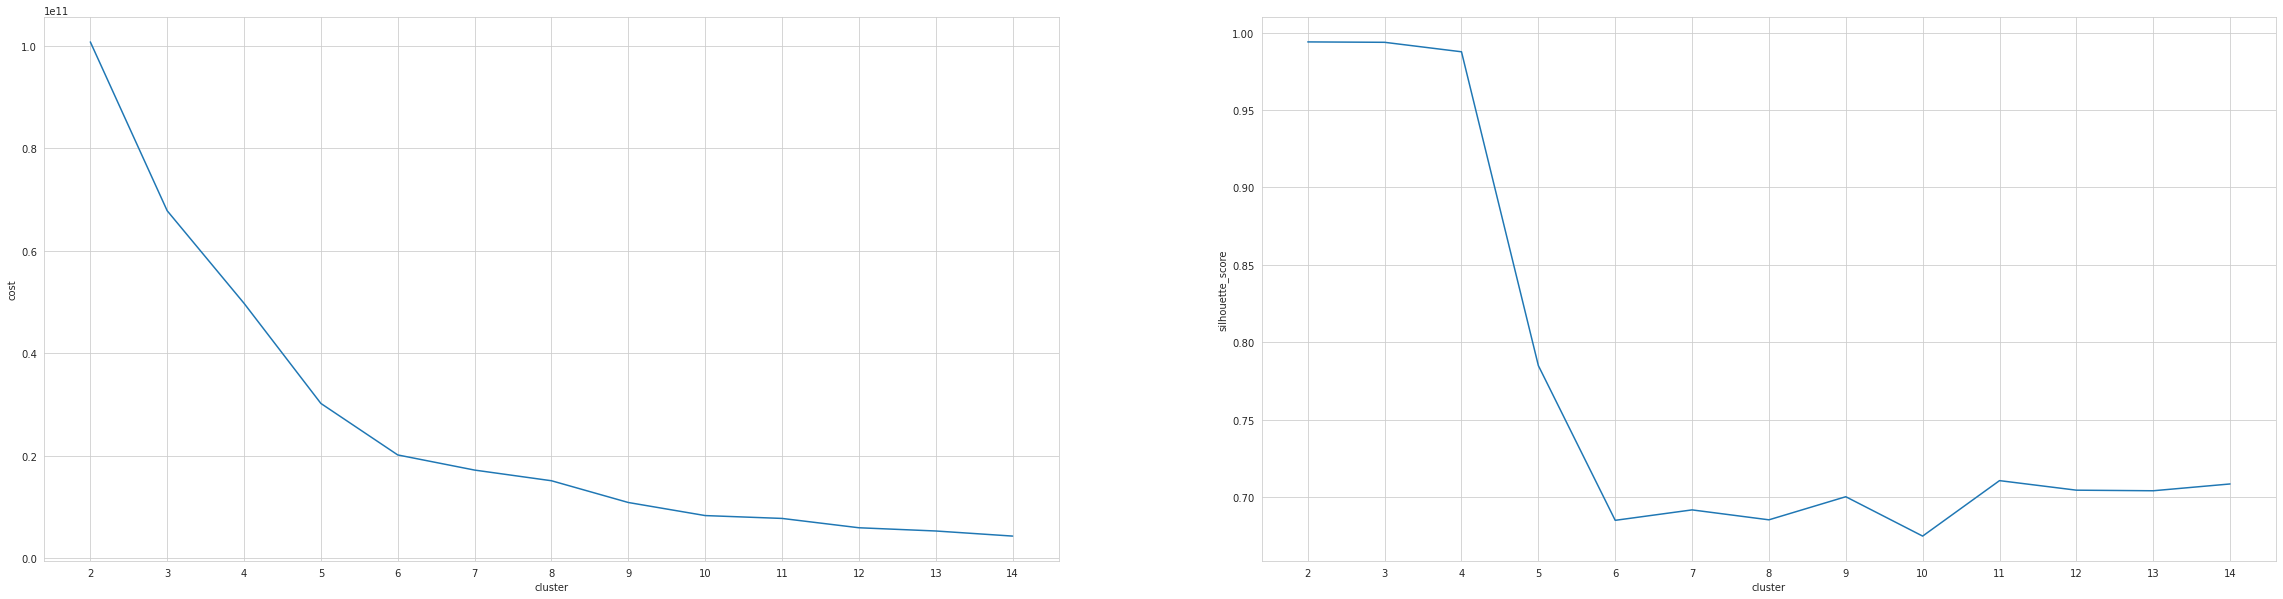

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set(xticks=range(2,15))
ax2 = fig.add_subplot(1, 2, 2)
ax2.set(xticks=range(2,15))
sns.lineplot(x='cluster', y='cost', data=df_eval, ax=ax1)
sns.lineplot(x='cluster', y='silhouette_score', data=df_eval, ax=ax2)

In [9]:
df_eval

,cluster,cost,silhouette_score
0,2,1.007589e+11,0.993991
1,3,6.781246e+10,0.993733
2,4,4.974666e+10,0.987616
3,5,3.020390e+10,0.785008
4,6,2.015361e+10,0.685087
5,7,1.719920e+10,0.691826
6,8,1.511783e+10,0.685413
7,9,1.087302e+10,0.700327
8,10,8.321896e+09,0.674909
9,11,7.763562e+09,0.710722


### We choose k=4 based on the plots above

In [5]:
kmeans = KMeans().setK(4).setFeaturesCol('features_pca')
model = kmeans.fit(papers_meta_transformed)
clusterdData = model.transform(papers_meta_transformed)

## Step 7 Recommender System

The goal here is to build a basic recommender the system that reccomends similar papers to a given title. When provided with a paper title, the recommender is only going to consider papers which belong to the same cluster. it will then run cosine similiraty between the given title and the processed paper titles in the database. it will return a dictionary with suggested paper titles and the cosine dot product with respect to the given title

In [6]:
paper_titles_df = spark.read\
            .format("parquet")\
            .option("header", "true")\
            .load("./Dataset/papers_meta_word2vec").select('Paper_ID', 'title', 'title_clean')
clusterdData = paper_titles_df.join(clusterdData, on=['Paper_ID'], how='inner')
clusterdData.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+--------------------+--------------------+----------+
|            Paper_ID|               title|         title_clean|             authors|             journal|wordcount|publish_Year|publish_Month|       word2vec_body|      word2vec_title|authors_index|journal_index|    authors_encoded|    journal_encoded|            features|        features_pca|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------+------------+-------------+--------------------+--------------------+-------------+-------------+-------------------+-------------------+--------------------+--------------------+----------+
|0782b4fb23ca65baf...|the population ge...|[population, gene...|Tibayrenc, Mich

### We will pre-calculate tf and idf values and store them in a dataframe named data for our recommender system.

In [7]:
from pyspark.sql.functions import udf, col
df_recommender = clusterdData.select('title', 'title_clean', col('prediction').alias('cluster'))
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="title_clean", outputCol="tf")
tf = hashingTF.transform(df_recommender)

idf = IDF(inputCol="tf", outputCol="idf_feature").fit(tf)
tfidf = idf.transform(tf)

In [8]:
from pyspark.ml.feature import Normalizer
normalizer = Normalizer(inputCol="idf_feature", outputCol="norm")
data = normalizer.transform(tfidf)

### We will define the recommendPaper function. it takes a paper title and returns N recommendations from the same cluster.

In [9]:
from pyspark.sql.types import DoubleType

dot_udf = udf(lambda x,y: float(x.dot(y)), DoubleType())

def recommendPaper(paper_title,N, data=data):
    target_paper = data.filter(data['title'] == paper_title)
    input_cluster = target_paper.select('cluster').collect()[0].cluster
    data = data.filter(data['cluster'] == input_cluster)
    recommendations = target_paper.alias("tearget_paper").crossJoin(data.alias("right"))\
        .select(col("tearget_paper.title").alias("target_title"), 
            col("right.title").alias("recommended_title"), 
            dot_udf("tearget_paper.norm", "right.norm").alias("dot"))\
        .sort(col("dot").desc())\
        .limit(N+1)
    return {reccomendation.recommended_title:reccomendation.dot for reccomendation in recommendations.collect()[1:]}

In [10]:
recommendPaper('the population genetics of trypanosoma cruzi revisited in the light of the predominant clonal evolution model',4)

{'effect of the plasmid dna vaccination on macroscopic and microscopic damage caused by the experimental chronic trypanosoma cruzi infection in the canine model': 0.2633751212982291,
 'ccr plays a critical role in the development of myocarditis and host protection in mice infected with trypanosoma cruzi': 0.2627314956954824,
 'renin angiotensin system revisited': 0.23883130343223866,
 'evolution of viruses': 0.1836250991049867}

In [11]:
recommendPaper('annual update in intensive care and emergency medicine',2)

{'annual update in intensive care and emergency medicine annual update in intensive care and emergency medicine': 0.9999999999999997,
 'annual update in intensive care and emergency medicine': 0.9999999999999997}

In [13]:
recommendPaper('use of simple laboratory features to distinguish the early stage of severe acute respiratory syndrome from dengue fever',3)

{'severe acute respiratory syndrome': 0.3645151517477996,
 'severe acute respiratory syndrome sars ': 0.3332956079500218,
 'a simple laboratory parameter facilitates early identification of covid patients': 0.3125342703495677}

In [14]:
recommendPaper('virology of hepatitis c virus',10)

{'hepatitis c virus rna replication': 0.5709986104132124,
 'hepatitis e a disease of reemerging importance basic virology and epidemiology of hepatitis e virus recent developments in hepatitis e': 0.44891119168862215,
 'glycyrrhizin as antiviral agent against hepatitis c virus': 0.4175231102580461,
 'amantadine in treatment of chronic hepatitis c virus infection ': 0.4156410776595072,
 'inhibition of hepatitis c virus replication by chloroquine targeting virus associated autophagy': 0.37790189679458763,
 'towards a small animal model for hepatitis c': 0.37450913307191663,
 'archives of virology mouse hepatitis virus nasoencephalopathy is dependent upon virus strain and host genotype': 0.3682394327277896,
 'by mouse hepatitis virus type ': 0.35835528698460356,
 'the role of type iii interferons in hepatitis c virus infection and therapy': 0.354883424906226,
 'characterization of antibodies induced by vaccination with hepatitis c virus envelope glycoproteins': 0.3543678425480336}